# Análisis de Series Temporales
## Primer Trabajo

#### Autores
 * TODO

In [1]:
rm(list = ls())
options(repr.plot.width=10, repr.plot.height=6)

In [2]:
library(magrittr)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(latex2exp)
require(reshape2)
library(forecast)

Loading required package: reshape2


In [3]:
lags <- 32

In [4]:
range_mean <- function(x, seasonality = 12) {
    n <- length(x)
    seq(1, n, by=seasonality) %>%
    sapply(function(i){
        a <- x[i:(i+seasonality)]
        c(mean=mean(a, na.rm=TRUE), range=diff(range(a,na.rm=TRUE)))
    }) %>%
    t() %>%
    as.data.frame()
} 

In [5]:
correlogram <- function(x, n = length(x) - 1, with.first = FALSE) {
    result <- acf(x, lag.max=n, plot=FALSE)$acf[1:n + !with.first]
    data.frame(lag = 1:length(result), values = result)
}

In [6]:
periodogram <- function(x) {
    result <- TSA::periodogram(x, plot=FALSE)
    data.frame(freq = c(0, result$freq), spec = c(0, result$spec))
}

In [7]:
plot.serie <- function(df, stationality, armonics = c()){
    p.a <- ggplot(df) + 
        aes(x = index, y = values) + 
        geom_line() 

    p.b <- ggplot(range_mean(df$values, stationality)) + 
        aes(x = mean, y = range) + 
        geom_point(size=3) + 
        expand_limits(y=0)

    p.c <- ggplot(correlogram(df$values, lags)) + 
        aes(x = lag, y = values) + 
        geom_bar(stat="identity") +
        geom_hline(yintercept = 2/sqrt(nrow(df)), color = "red") +
        geom_hline(yintercept = -2/sqrt(nrow(df)), color = "red")

    p.d <- ggplot(periodogram(df$values)) + 
        aes(x = freq, y = spec) + 
        geom_line()
    
    for (a in armonics) {
        p.d <- p.d + geom_vline(xintercept = a, color = "red", alpha = 0.4)
    }
    cowplot::plot_grid(p.a, p.b, p.c, p.d)
}

# Sea $\{Y_t\}$ un proceso estacionario con media cero, sean $a$ y $b$ constantes.

En este caso se van a realizar distintas simulaciones para series temporales. Dichas series estarán compuestas por ciertas constantes, las cuales se indican a continuación:

In [8]:
a <- 2
b <- 0.25
sigma <- 2
n <- 204

In [9]:
data.frame(Variable = "Valor", a = a, b = b, sigma = sigma, n = n)

Variable,a,b,sigma,n
Valor,2,0.25,2,204


## Sea $X_t = a + b \cdot t + s_t + Y_t$ donde $s_t$ es una componente estacional con periodo $12$. Simular $204$ datos para $X_t$. Hacer el plot de la serie, el plot rango-media, el correlograma y el periodograma.

Para esta serie es necesario determinar los coeficientes estacionales (en este caso $12$). Puesto que la serie será de carácter aditivo, vamos a imponer la restricción de que todos ellos sumen $0$. Los valores escogidos son los siguientes:

In [10]:
s.a <- c(1, 2, 3, 4, 5, 6, -6, -5, -4, -3, -2, -1)
y.a <- rnorm(n, sd = sigma)
x.a <- a + b * (1:n) + rep(s.a, length.out=n) + y.a
df.a <- data.frame(index = 1:length(x.a), values = x.a)

In [11]:
data.frame("Retardo" = 1:12, "Coef Estacional" = s.a) %>%
    mutate_if(is.numeric, round, digits = 4) %>%
    mutate_all(as.character) %>% 
    t()

Retardo,1,2,3,4,5,6,7,8,9,10,11,12
Coef.Estacional,1,2,3,4,5,6,-6,-5,-4,-3,-2,-1


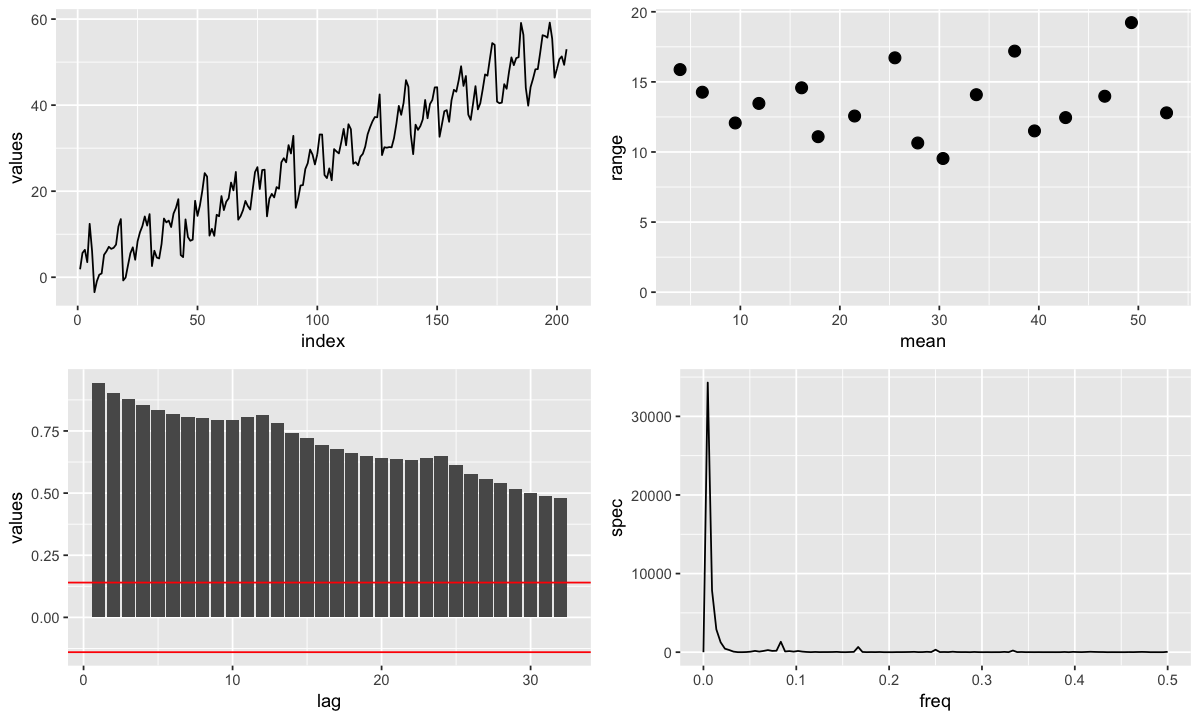

In [12]:
plot.serie(df.a, stationality = 12)

A continuación se analizan los gráficos generados. En el caso del gráfico de la serie, se puede apreciar una marcada tendencia creciente (lo cual era de esperar dadas las constantes escogidas). También se puede apreciar la estructura estacional escogida, con un gran decrecimiento repentino en la zona intermedia de cada periodo. 

En cuanto al gráfico de dispersión *rango-media*, debido al modelo aditivo subyacente, no se aprecia correlación entre la media y el rango por lo que podemos asumir una varianza constante. 

Para el caso del correlograma, se puede apreciar la estacionalidad de la serie, con pequeños escalones de periodo $12$. Debido al decrecimiento que se muestra en la misma, podemos afirmar que no es estacionaria (se había construido para que no lo fuera). Esta serie no es estacionaria debido a la componente regular.

En cuanto al periodograma, este refleja una fuerte correlación con el primer retardo. Se cree que esto es algo debido a la fuerte tendencia creciente, que oculta la estacionalidad (se comprobará que es cierto cuando se realicen las pertinentes diferenciaciones de la serie).

## Sea $X_t =(a + b \cdot t) \cdot s_t + Y_t$ donde $s_t$ es otra vez una componente estacional con periodo $12$. Simular $n = 204$ datos para $X_t$. Hacer el plot de la serie, el plot rango-media, el correlograma y el periodograma.

Para esta serie es necesario determinar los coeficientes estacionales (en este caso $12$). Puesto que la serie será de carácter multiplicativo, vamos a imponer la restricción de que todos ellos sumen $12$. Los valores escogidos son los siguientes:

In [13]:
s.b <- c(1, -2, 3, 4, 5, 6, 1/6, -1/5, 1/4, 1/3, 1/2, 1) * 12
y.b <- rnorm(n, sd = sigma)
x.b <- (a + b * (1:n)) * rep(s.b, length.out=n) + y.a
df.b <- data.frame(index = 1:length(x.b), values = x.b)

In [14]:
data.frame("Retardo" = 1:12, "Coef Estacional" = s.b) %>%
    mutate_if(is.numeric, round, digits = 3) %>%
    mutate_all(as.character) %>% 
    t()

Retardo,1,2,3,4,5,6,7,8,9,10,11,12
Coef.Estacional,12,-24,36,48,60,72,2,-2.4,3,4,6,12


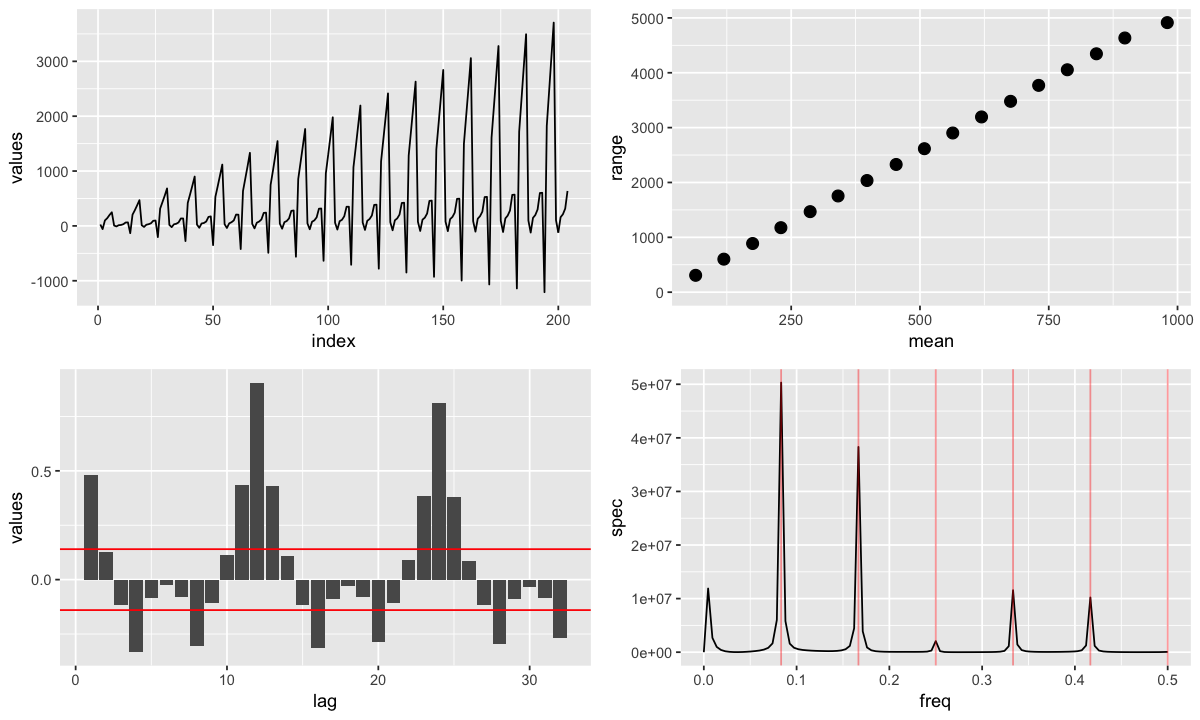

In [15]:
plot.serie(df.b, stationality = 12, armonics = 1:6/12)

A continuación se analizan los gráficos generados. En el caso del gráfico de la serie, se puede apreciar que en este caso no hay tendencia, lo cual era esperable por la estructura del modelo subyacente. También se puede apreciar la estructura estacional escogida, con un gran decrecimiento repentino en la zona intermedia de cada periodo. 

En cuanto al gráfico de dispersión *rango-media*, debido al modelo multiplicativo subyacente, se aprecia una elevada correlación entre el la media y el rango, por tanto podemos afirmar que esta es variable respecto del eje de abscisas. 

Para el caso del correlograma, se aprecia una marcada estacionalidad de la serie, con escalones de periodo $12$. Debido al decrecimiento lineal que se muestra en la misma, podemos afirmar que no es estacionaria (se había construido para que no lo fuera). Esta serie no es estacionaria debido a la componente estacional.

En cuanto al periodograma, este refleja una marcada estacionalidad determinista de periodo 12. Esto es algo esperable debido a la construcción de la serie. Dado que en este caso, na serie no tiene tendencia, hemos podido apreciarla sin tener que realizar diferenciaciones.

## Para las series obtenidas en los apartados anteriores, tomar las siguientes diferenciaciones: $\nabla X_t$, $\nabla_{12} X_t$, $\nabla \nabla_{12} X_t$, $\nabla^{2}_{12} X_t$) y comentar el efecto que éstas producen adjuntando los gráficos necesarios.

A continuación se desarrollan las diferenciaciones para tratar de poder comprender mejor su actuación sobre la serie de partida:

* Diferenciación Regular:

\begin{align*}
  \nabla X_t 
  &= (1 - B) X_t \\
  &= X_t - X_{t-1}
\end{align*}

In [16]:
dif_1 <- function(x) {
    d <- diff(x, lag = 1)
    data.frame(index = 1:length(d), values = d)
}

* Diferenciación Estacional (periodo 12)

\begin{align*}
  \nabla_{12} X_t 
  &= (1 - B^{12}) X_t \\
  &= X_t - X_{t-12}
\end{align*}

In [17]:
dif_12 <- function(x) {
    d <- diff(x, lag = 12)
    data.frame(index = 1:length(d), values = d)
}

* Diferenciación Estacional (periodo 12) con un retardo regular

 
\begin{align*}
  \nabla \nabla_{12} X_t  
  &= (1 - B)(1 - B^{12}) X_t \\
  &= (1 - B) (X_t - X_{t-12}) \\
  &= X_t - X_{t-1} - X_{t-12} + X_{t-13}
\end{align*}

In [18]:
dif_1_12 <- function(x) {
    d <- diff(diff(x, lag = 12), lag = 1)
    data.frame(index = 1:length(d), values = d)
} 

* Diferenciación Estacional (periodo 12) con dos diferenciaciones:

\begin{align*}
  \nabla^{2}_{12} X_t 
  &= (1 - B^{12})^{2} X_t \\
  & = (1 - B^{12})(1 - B^{12}) X_t \\
  &= X_t - 2 \cdot X_{t-12}+X_{t-24}
\end{align*}

In [19]:
dif_12_12 <- function(x) {
    d <- diff(x, lag = 12, differences = 2)
    data.frame(index = 1:length(d), values = d)
}

### Modelo Aditivo

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación de un retardo (regular):

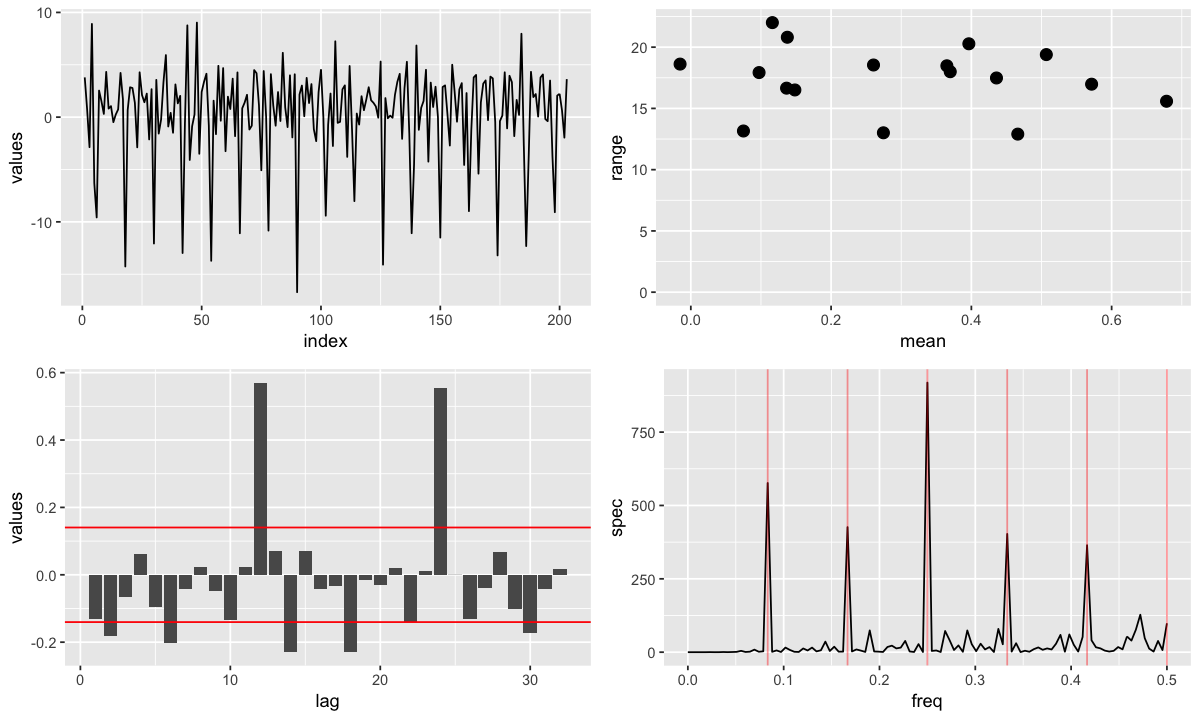

In [20]:
plot.serie(dif_1(x.a), stationality = 12, armonics = 1:6/12)

Gracias a la primera diferenciación se consigue eliminar la tendencia (en el plot de la serie se puede ver como ya no un patrón claro de crecimiento o decrecimiento). Sigue estando, presente, sin embargo, la estacionalidad, pues el correlograma indica autocorrelación alta en los retardos 12 y 24 (múltiplos del período, 12).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación de 12 retardos (estacional):

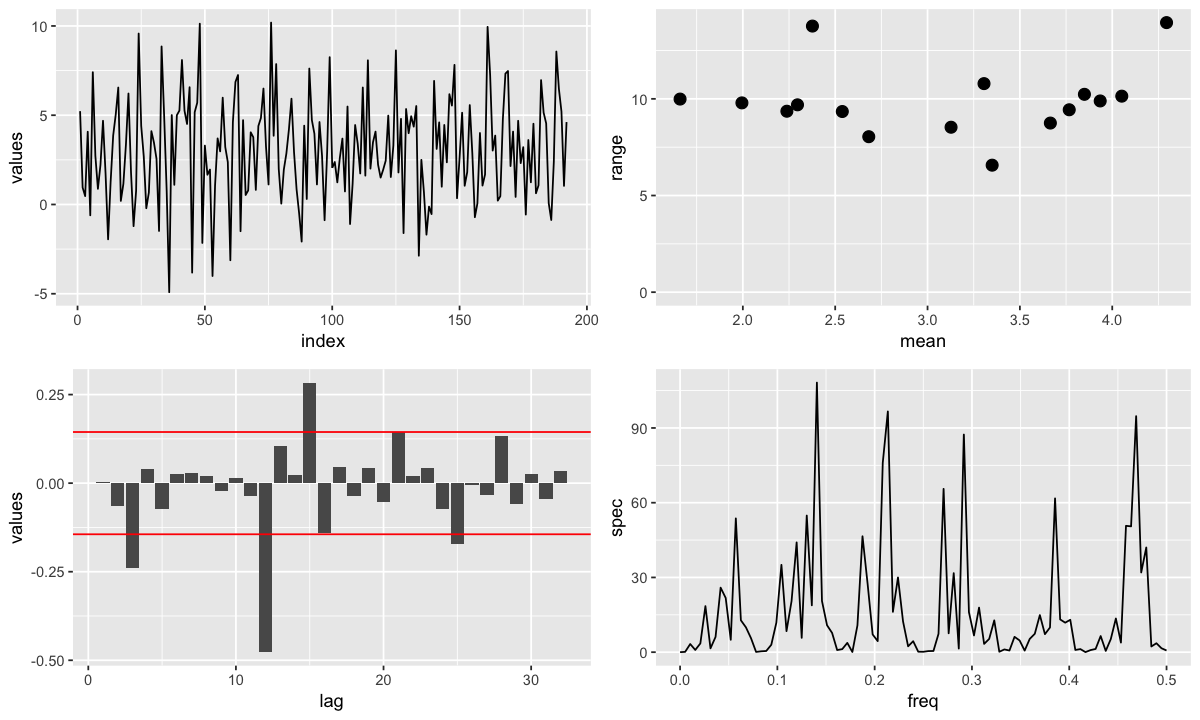

In [21]:
plot.serie(dif_12(x.a), stationality = 12)

Con la segunda diferenciación (12 retardos) se consigue eliminar la tendencia y parcialmente la estacionalidad. La explicación de la tendencia es la misma que para la diferenciación anterior (además, el correlograma no presenta el decrecimiento exponencial característico de la estacionaridad). La estacionalidad no desaparece por completo, puesto que la barra del retardo 12 muestra una autocorrelación alta.

Las dos diferenciaciones siguientes consiguen unos efectos muy similares a la anterior, por lo que la segunda es la más adecuada atendiendo al criterio de mínima diferenciación que elimina tendencia y/o estacionalidad.

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación compuesta de 12 retardos (estacional) y 1 retardo (regular):

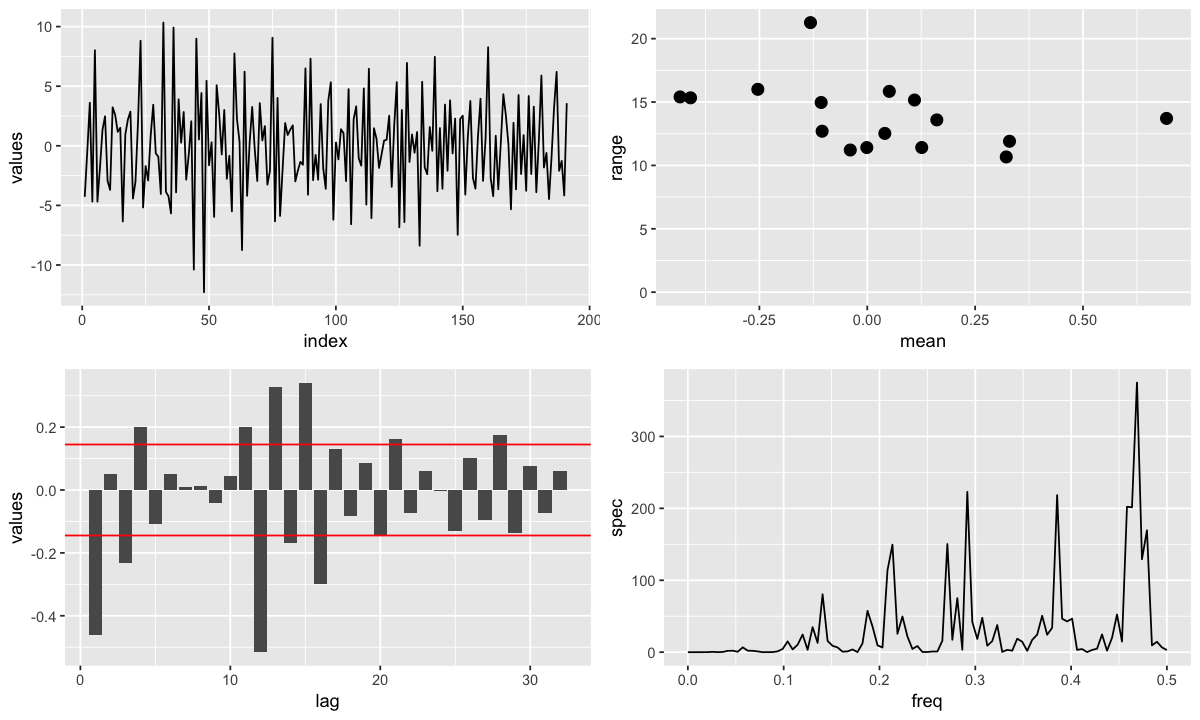

In [22]:
plot.serie(dif_1_12(x.a), stationality = 12)

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con 2 diferenciaciones de 12 retardos (estacional):

In [23]:
x.a.dif_12_12 <- dif_12_12(x.a)

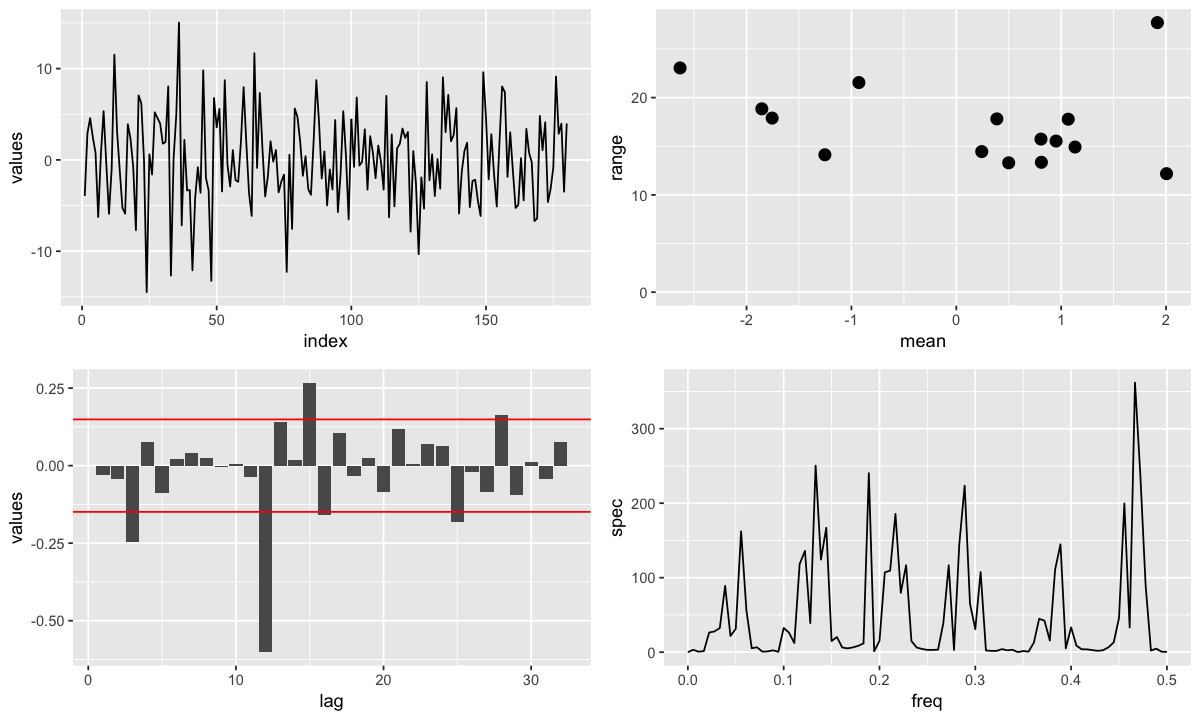

In [24]:
plot.serie(x.a.dif_12_12, stationality = 12)

### Modelo Multiplicativo

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con una diferenciación de un retardo (regular):

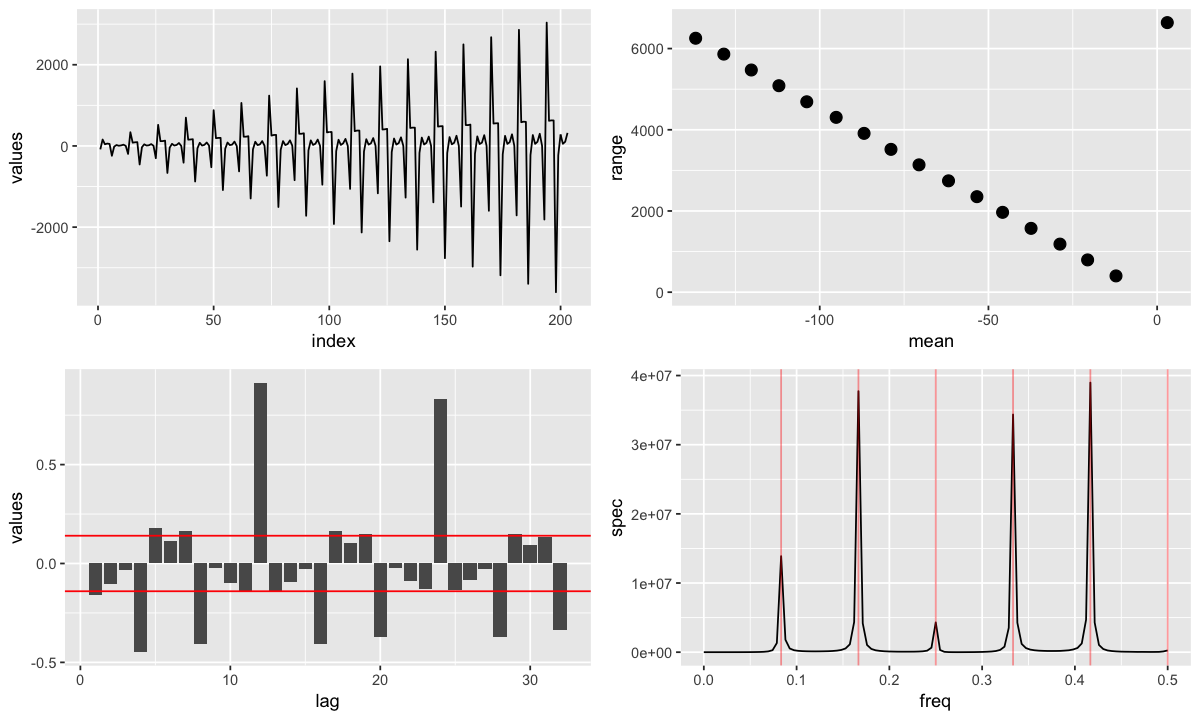

In [25]:
plot.serie(dif_1(x.b), stationality = 12, armonics = 1:6/12)

Con la primera diferenciación se elimina la tendencia. La estacionalidad sigue presente (barras 12 y 24 muestran alta autocorrelación; apreciable también en el periodograma en las frecuencias 1/12 = 0.083,  2/12 = 0.167, etc. que recogen mucha varianza).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con una diferenciación de 12 retardos (estacional):

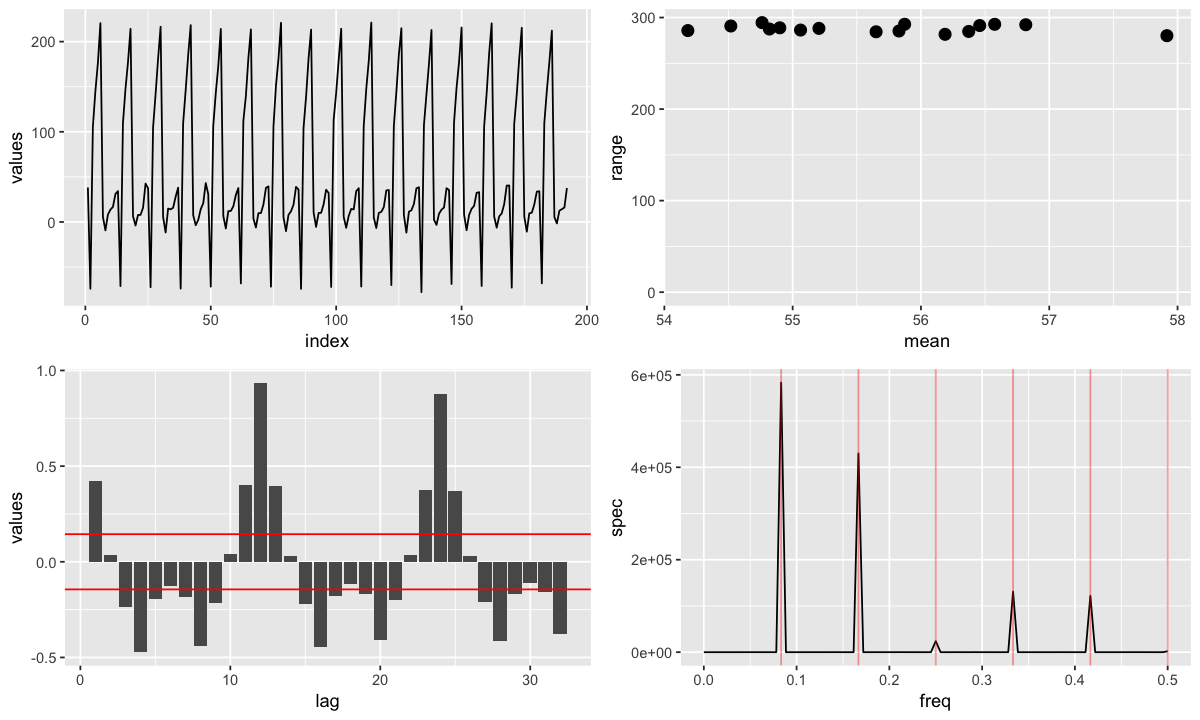

In [26]:
plot.serie(dif_12(x.b), stationality = 12,armonics = 1:6/12)

Con el resto de diferenciaciones también se elimina la tendencia. Ni la segunda ni la tercera diferenciación consiguen eliminar la estacionalidad (las barras 12 y 24 aparecen muy destacadas en los correlogramas).

Al igual que en el modelo aditivo, no se consigue eliminar completamente la estacionalidad con ninguna diferenciación. Sin embargo, la cuarta diferenciación la elimina parcialmente (se conserva la autocorrelación alta en el retardo 12).

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter aditivo con una diferenciación compuesta de 12 retardos (estacional) y 1 retardo (regular):

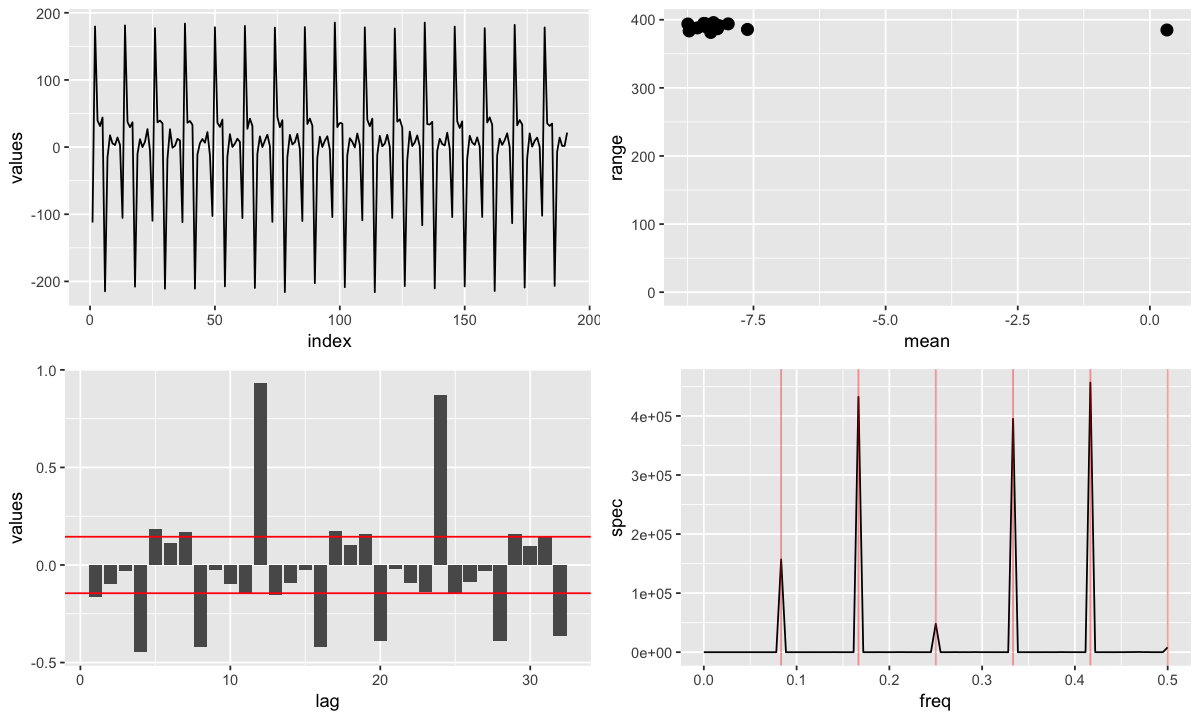

In [27]:
plot.serie(dif_1_12(x.b), stationality = 12,armonics = 1:6/12)

En este caso, el plot rango media presenta un *outlier* que creemos que se debe a las los puntos de partición, que dejan uno de ellos descompensado respecto del resto, ya que $(204 - 13) \ mod \ 12 \neq 0$.

A continuación se muestran los gráficos de la serie simuladada perteneciente a un modelo de carácter multiplicativo con 2 diferenciaciones de 12 retardos (estacional):

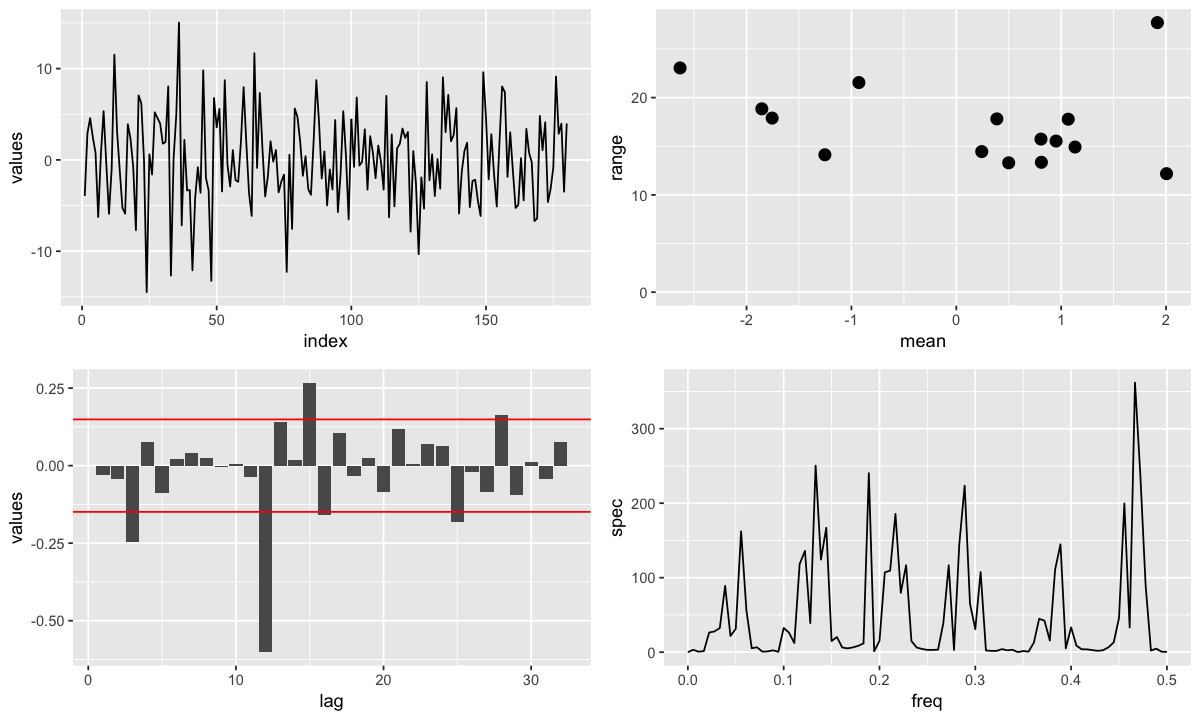

In [28]:
plot.serie(dif_12_12(x.b), stationality = 12)